In [16]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import gc

import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

import tensorflow_data_validation as tfdv
from tensorflow_metadata.proto.v0 import schema_pb2, statistics_pb2

In [4]:
path = 'src/data/'

In [5]:
def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [6]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']

In [81]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [84]:
train = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)
train['click_time'] = pd.to_datetime(train['click_time'])

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ip             100000 non-null  uint32        
 1   app            100000 non-null  uint16        
 2   device         100000 non-null  uint16        
 3   os             100000 non-null  uint16        
 4   channel        100000 non-null  uint16        
 5   click_time     100000 non-null  datetime64[ns]
 6   is_attributed  100000 non-null  uint8         
dtypes: datetime64[ns](1), uint16(4), uint32(1), uint8(1)
memory usage: 2.0 MB


In [86]:
train_stats = tfdv.generate_statistics_from_dataframe(train)

In [87]:
tfdv.visualize_statistics(train_stats)

In [88]:
schema = tfdv.infer_schema(statistics=train_stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'ip',INT,required,,-
'app',INT,required,,-
'device',INT,required,,-
'os',INT,required,,-
'channel',INT,required,,-
'is_attributed',INT,required,,-


In [89]:
# set domain
features = ['app', 'device', 'os', 'channel']
for feature in features:
    os_feature = tfdv.get_feature(schema, feature)
    tfdv.set_domain(schema, feature, 
                    schema_pb2.IntDomain(name=f'{feature}_type', 
                                         min=train.loc[:, feature].min(), max=train.loc[:, feature].max(), 
                                         is_categorical=True)
                   )

In [65]:
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'ip',INT,required,,-
'app',INT,required,,min: 1; max: 551
'device',INT,required,,min: 0; max: 3867
'os',INT,required,,min: 0; max: 866
'channel',INT,required,,min: 3; max: 498
'click_time',BYTES,required,,-
'is_attributed',INT,required,,-


In [66]:
stats_options = tfdv.StatsOptions(schema=schema, infer_type_from_schema=True, label_feature='is_attributed')

In [67]:
train_stats = tfdv.generate_statistics_from_dataframe(train, stats_options=stats_options)

In [68]:
tfdv.visualize_statistics(train_stats)

In [69]:
anomalies = tfdv.validate_statistics(train_stats, schema=schema)

In [75]:
schema.default_environment.append('TRAINING')
schema.default_environment.append('SERVING')

In [76]:
tfdv.get_feature(schema, 'is_attributed').not_in_environment.append('SERVING')

In [77]:
tfdv.write_schema_text(schema, 'src/data/schema/schema.pbtxt')

In [78]:
read_schema = tfdv.load_schema_text('src/data/schema/schema.pbtxt')

In [79]:
tfdv.display_schema(read_schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'ip',INT,required,,-
'app',INT,required,,min: 1; max: 551
'device',INT,required,,min: 0; max: 3867
'os',INT,required,,min: 0; max: 866
'channel',INT,required,,min: 3; max: 498
'click_time',BYTES,required,,-
'is_attributed',INT,required,,-


In [7]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [8]:
# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

In [9]:
train = timeFeatures(train)
gc.collect()

127

In [10]:
# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [11]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
# del x1, y1, x2, y2 
gc.collect()
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
del dvalid

[19:54:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.79005	valid-auc:0.90908
[5]	train-auc:0.96031	valid-auc:0.97767


/Users/Dhaval.Mayatra/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[10]	train-auc:0.96775	valid-auc:0.97637
[15]	train-auc:0.98921	valid-auc:0.97999
[20]	train-auc:0.99736	valid-auc:0.98280
[25]	train-auc:0.99923	valid-auc:0.97694
[30]	train-auc:0.99950	valid-auc:0.97831
[35]	train-auc:0.99967	valid-auc:0.97519
[36]	train-auc:0.99968	valid-auc:0.97602


In [24]:
x2

,ip,app,device,os,channel,dow,doy
86155,52076,13,1,15,469,2,312
29633,208415,3,1,18,280,2,312
67710,114273,12,1,13,245,2,312
62348,83639,18,1,19,107,3,313
98787,14058,18,1,28,121,3,313
...,...,...,...,...,...,...,...
54140,123871,15,1,8,265,1,311
53535,53976,18,3543,748,107,2,312
1025,149223,14,1,20,379,3,313
33099,160294,5,1,30,113,1,311


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

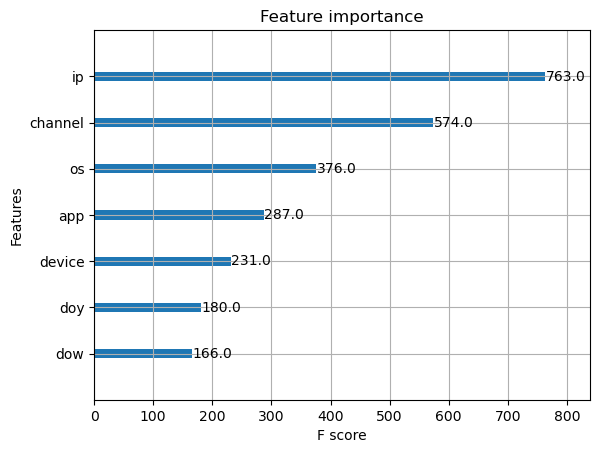

In [12]:
# Plot the feature importance from xgboost
plot_importance(model)

In [13]:
model.save_model('src/data/model/xgboost_bst.ubj')

In [18]:
test = xgb.DMatrix(x2)
predictions = model.predict(test)

In [23]:
list(predictions > 0.5)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 F

In [22]:
(np.array([0, 0.1, 0.7, 1]) > 0.5)

array([False, False,  True,  True])

In [30]:
train = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)

train.loc[:, train.columns.difference(['is_attributed', 'attributed_time'])].to_json('src/data/input_samples.json', orient='records')

In [ ]:
train.to_dict()